<a href="https://colab.research.google.com/github/hoogencj/Deep-Learning-Final/blob/main/NBABetting1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Set Up

In [ ]:
! pip install torch_utils

  Created wheel for torch-utils: filename=torch_utils-0.1.2-cp37-none-any.whl size=6191 sha256=1c7eec51ffbc168b05c8d037dbd36da644b88159b2d2d9c4d9651c26d68a71fc
  Stored in directory: /root/.cache/pip/wheels/95/61/06/139d254fa820bc1e45087dba1d719bc7d4007aec98905179c7
Successfully built torch-utils


In [ ]:
%ls

games_ordered.csv  nba_betting_spread.csv  nba_betting_totals.csv  sample_data/


In [ ]:
import numpy as np
from numpy import inf
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch import cuda
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, sampler
import torch.nn.functional as F
from torch_utils import AverageMeter

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import math

import torchvision

from sklearn.model_selection import train_test_split
import os
from torchvision import transforms
from torchvision import datasets
from torchvision import models
from torch import optim, cuda, Tensor

from timeit import default_timer as timer

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data Preparation

In [ ]:
games = pd.read_csv('games_ordered.csv')
# drop two duplicate columns
games = games.drop(['TEAM_ID_home', 'TEAM_ID_away'], axis=1)
for i in games:
  print((i, games[i][0]))
print(games)

('GAME_DATE_EST', '10/5/2003')
('GAME_ID', 10300001)
('GAME_STATUS_TEXT', 'Final')
('HOME_TEAM_ID', 1610612762)
('VISITOR_TEAM_ID', 1610612742)
('SEASON', 2003)
('PTS_home', 90.0)
('FG_PCT_home', 0.457)
('FT_PCT_home', 0.735)
('FG3_PCT_home', 0.14300000000000002)
('AST_home', 23.0)
('REB_home', 41.0)
('PTS_away', 85.0)
('FG_PCT_away', 0.447)
('FT_PCT_away', 0.5)
('FG3_PCT_away', 0.25)
('AST_away', 20.0)
('REB_away', 38.0)
('HOME_TEAM_WINS', 1)
      GAME_DATE_EST   GAME_ID  ... REB_away  HOME_TEAM_WINS
0         10/5/2003  10300001  ...     38.0               1
1         10/6/2003  10300002  ...     43.0               1
2         10/7/2003  10300006  ...      NaN               0
3         10/7/2003  10300010  ...     37.0               1
4         10/7/2003  10300003  ...     52.0               0
...             ...       ...  ...      ...             ...
24190     3/21/2021  22000648  ...     37.0               1
24191     3/21/2021  22000649  ...     52.0               0
24192     3/

Now we need to process the data to get the data we want. We define a function that builds each teams statsa for the last ten games before a given game. 

In [ ]:
class team: 
  def __init__(self, games, team):
    home = games.loc[games['HOME_TEAM_ID'] == team]
    away = games.loc[games['VISITOR_TEAM_ID'] == team]

    for i in home:
      if i == 'HOME_TEAM_WINS':
        home = home.rename({i: 'TEAM_WINS'}, axis=1)
      elif 'away' in i:
        home = home.rename({i: i.replace('away', 'against')}, axis=1)
      else:
        home = home.rename({i: i.replace('_home', '')}, axis=1)
    
    for i in away:
      if i == 'HOME_TEAM_WINS':
        away[i] = away[i].replace({0:1, 1:0})
        away = away.rename({i: 'TEAM_WINS'}, axis=1)
      elif 'home' in i:
        away = away.rename({i: i.replace('home', 'against')}, axis=1)
      else:
        away = away.rename({i: i.replace('_away', '')}, axis=1)      

    self.history = home.append(away).sort_index()

  def getlastn(self, n, columns, index):
    prev_index = index - 1
    return self.history.loc[:prev_index].tail(n)[columns]

  def get_avg_lastn(self, n, columns, index):
    lastn = self.getlastn(n, columns, index)
    lastn = lastn.agg('mean').rename(index)
    return lastn

  def get_season(self, columns, index): 
    prev_index = index - 1
    season = self.history.loc[index]['SEASON']
    history = self.history.loc[:prev_index]
    history = history.loc[history['SEASON'] == season][columns]
    return history

  def get_season_avg(self, columns, index):
    season = self.get_season(columns, index)
    return season.agg('mean').rename(index)
  
  def print_history(self, n=0):
    if n < 1:
      print(self.history.to_string())
    else:
      print(self.history.head(n).to_string())

team_ids = games['HOME_TEAM_ID'].unique()
team_hist = {}
for team_id in team_ids:
  team_hist[team_id] = team(games,team_id)
team_hist[team_ids[0]].print_history(5)

   GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON   PTS  FG_PCT  FT_PCT  FG3_PCT   AST   REB  PTS_against  FG_PCT_against  FT_PCT_against  FG3_PCT_against  AST_against  REB_against  TEAM_WINS
0      10/5/2003  10300001            Final    1610612762       1610612742    2003  90.0   0.457   0.735    0.143  23.0  41.0         85.0           0.447             0.5             0.25         20.0         38.0          1
35    10/11/2003  10300038            Final    1610612762       1610612760    2003   NaN     NaN     NaN      NaN   NaN   NaN          NaN             NaN             NaN              NaN          NaN          NaN          0
46    10/14/2003  10300052            Final    1610612762       1610612752    2003   NaN     NaN     NaN      NaN   NaN   NaN          NaN             NaN             NaN              NaN          NaN          NaN          0
59    10/16/2003  10300061            Final    1610612762       1610612753    2003   NaN     NaN    

In [ ]:
fields = ['PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB', 'PTS_against', 'FG_PCT_against', 'FT_PCT_against', 'FG3_PCT_against', 'AST_against', 'REB_against', 'TEAM_WINS']
homeL10 = pd.DataFrame(columns=fields)
awayL10 = pd.DataFrame(columns=fields)
home_season = pd.DataFrame(columns=fields)
away_season = pd.DataFrame(columns=fields)
for index, game in games.iterrows():
  home_id, away_id = game['HOME_TEAM_ID'], game['VISITOR_TEAM_ID']
  homeL10 = homeL10.append(team_hist[home_id].get_avg_lastn(10, fields, index))
  awayL10 = awayL10.append(team_hist[away_id].get_avg_lastn(10, fields, index))
  home_season = home_season.append(team_hist[home_id].get_season_avg(fields, index))
  away_season = away_season.append(team_hist[away_id].get_season_avg(fields, index))

In [ ]:
home_fields = []
away_fields = []
for f in fields:
  home_fields.append(f + "_homeL10")
  away_fields.append(f + "_awayL10")

homeL10.set_axis(home_fields, axis=1, inplace=True)
awayL10.set_axis(away_fields, axis=1, inplace=True)

home_fields = []
away_fields = []
for f in fields:
  home_fields.append(f + "_home_AVG")
  away_fields.append(f + "_away_AVG")

home_season.set_axis(home_fields, axis=1, inplace=True)
away_season.set_axis(away_fields, axis=1, inplace=True)

games = games.join(homeL10).join(awayL10).join(home_season).join(away_season).fillna(0)
print(games.head().to_string())

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  REB_home  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  HOME_TEAM_WINS  PTS_homeL10  FG_PCT_homeL10  FT_PCT_homeL10  FG3_PCT_homeL10  AST_homeL10  REB_homeL10  PTS_against_homeL10  FG_PCT_against_homeL10  FT_PCT_against_homeL10  FG3_PCT_against_homeL10  AST_against_homeL10  REB_against_homeL10  TEAM_WINS_homeL10  PTS_awayL10  FG_PCT_awayL10  FT_PCT_awayL10  FG3_PCT_awayL10  AST_awayL10  REB_awayL10  PTS_against_awayL10  FG_PCT_against_awayL10  FT_PCT_against_awayL10  FG3_PCT_against_awayL10  AST_against_awayL10  REB_against_awayL10  TEAM_WINS_awayL10  PTS_home_AVG  FG_PCT_home_AVG  FT_PCT_home_AVG  FG3_PCT_home_AVG  AST_home_AVG  REB_home_AVG  PTS_against_home_AVG  FG_PCT_against_home_AVG  FT_PCT_against_home_AVG  FG3_PCT_against_home_AVG  AST_against_home_AVG  REB_against_home_AVG  TEAM_WINS_home_AVG  PTS_away_AVG  FG_PC

Next want to use each Vegas spread/OU and build a distribution of differences from line. 
**Important**: team_id is away, a_team_id is home, spread 1 is away spread, spread2 is home spread. 

In [ ]:
spreads = pd.read_csv('nba_betting_spread.csv')
O_U = pd.read_csv('nba_betting_totals.csv')
spreads = spreads.loc[spreads['book_name'] == '5Dimes']
O_U = O_U.loc[O_U['book_name'] == '5Dimes']
# join = pd.merge(games, spreads, left_on=['GAME_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_ID'], right_on=['game_id', 'team_id', 'a_team_id'])
# data = join.dropna().drop(['game_id', 'book_name', 'book_id', 'team_id', 'a_team_id', 'price1', 'price2'], axis=1)
betting = pd.merge(spreads, O_U)
print(betting.head().to_string())

    game_id book_name  book_id     team_id   a_team_id  spread1  spread2  price1  price2  total1  total2
0  21000358    5Dimes       19  1610612749  1610612742      7.5     -7.5  -110.0  -110.0   183.5   183.5
1  21000361    5Dimes       19  1610612755  1610612751     -1.5      1.5  -105.0  -105.0   190.5   190.5
2  21000372    5Dimes       19  1610612766  1610612763      8.5     -8.5  -107.0  -103.0   186.0   186.0
3  21000384    5Dimes       19  1610612751  1610612761      5.5     -5.5  -105.0  -105.0   203.0   203.0
4  21000421    5Dimes       19  1610612739  1610612737      9.5     -9.5  -105.0  -105.0   191.5   191.5


# Basic Win/Loss Networks

Now we define an initial basic network.


In [ ]:
def train(model, 
          criterion, 
          optimizer, 
          train_loader, 
          val_loader, 
          max_epochs_stop=3, 
          n_epochs=10,
          early_stop=False, 
          save_file_name=f'best_model.pt'):
  #early stoping init
  epochs_no_improve = 0
  valid_loss_min = np.Inf
  valid_max_acc = 0
  history = []

  # Number of epochs already trained (if using loaded in model weights)
  try:
    print(f'Model has been trained for: {model.epochs} epochs.\n')
  except:
    model.epochs = 0
    print(f'Starting Training from Scratch.\n')

  overall_start = timer()

  for epoch in range(n_epochs):
    train_loss = 0
    valid_loss = 0

    train_acc = 0
    valid_acc = 0

    model.train()
    start = timer()

    for x, y in train_loader:
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)

      loss = criterion(output, y)

      loss.backward()
      optimizer.step()

      train_loss += loss.item() * y.size(0)
    
    # Validation
    with torch.no_grad():
      model.epochs += 1
      model.eval()

      for x, y in val_loader:
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = criterion(output, y)

        valid_loss += loss.item() * y.size(0)


      # Calculate average losses                
      train_loss = train_loss / len(train_loader.dataset)
      valid_loss = valid_loss / len(val_loader.dataset)  

      history.append([train_loss, valid_loss])

      print(
          f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
      )

            # Save the model if validation loss decreases
      if valid_loss < valid_loss_min:
          # Save model
          torch.save(model.state_dict(), save_file_name)
          # Track improvement
          epochs_no_improve = 0
          valid_loss_min = valid_loss
          valid_best_acc = valid_acc
          best_epoch = epoch

      else:
          epochs_no_improve += 1
          # Trigger early stopping
          if epochs_no_improve >= max_epochs_stop:
              print(
                  f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.5f}'
              )
              # Load the best state dict                        
              model.load_state_dict(torch.load(save_file_name))

              model.optimizer = optimizer
              history = pd.DataFrame(history, columns=['train_loss', 'valid_loss'])

              return model, history

    
  model.optimizer = optimizer
  history = pd.DataFrame(history, columns=['train_loss', 'valid_loss'])
  return model, history


In [ ]:
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

In [ ]:
data = games[games['SEASON'].isin(range(2013, 2020))]
X = data[['TEAM_WINS_homeL10', 'TEAM_WINS_awayL10']]
Y = data[['HOME_TEAM_WINS']]

# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size=0.2, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 30

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

Below we define a simple neaural net designed to predict the winnner of a game based on their record in the last 10. 

In [ ]:
# define model
class bmodel(nn.Module):
    def __init__(self, nin):
        super(bmodel, self).__init__()
        
        self.lin1 = nn.Linear(nin, 4)
        # self.lin2 = nn.Linear(4, 2)
        self.out = nn.Linear(4, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.lin1(x))
        # x = self.relu(self.lin2(x))
        x = self.out(x)

        return x

In [ ]:
epochs = 50
lr = .001

nin = len(X.columns)

model = bmodel(nin)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model, history = train(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    val_loader, 
    n_epochs=epochs, 
    early_stop=True)

cuda:0


bmodel(
  (lin1): Linear(in_features=2, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.2484 	Validation Loss: 0.2404

Epoch: 1 	Training Loss: 0.2408 	Validation Loss: 0.2373

Epoch: 2 	Training Loss: 0.2380 	Validation Loss: 0.2338

Epoch: 3 	Training Loss: 0.2350 	Validation Loss: 0.2299

Epoch: 4 	Training Loss: 0.2325 	Validation Loss: 0.2266

Epoch: 5 	Training Loss: 0.2304 	Validation Loss: 0.2244

Epoch: 6 	Training Loss: 0.2289 	Validation Loss: 0.2227

Epoch: 7 	Training Loss: 0.2280 	Validation Loss: 0.2222

Epoch: 8 	Training Loss: 0.2277 	Validation Loss: 0.2210

Epoch: 9 	Training Loss: 0.2273 	Validation Loss: 0.2210

Epoch: 10 	Training Loss: 0.2271 	Validation Loss: 0.2208

Epoch: 11 	Training Loss: 0.2270 	Validation Loss: 0.2208

Epoch: 12 	Training Loss: 0.2268 	Validation Loss: 0.2202

Epoch: 13 	Training Loss: 0.2268 	Validation Loss: 0.2202

Epoch: 14 	Training Loss: 0.2268 	Validation Loss: 0.2210

Epoch: 15 	Training Loss: 0.2268 	Validation Loss: 0.2207

Early Stopping! Total epochs: 15

0.5723888314374354


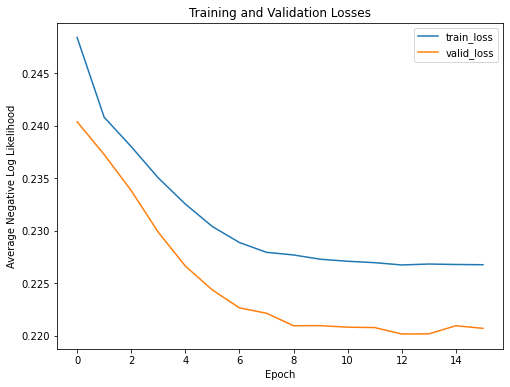

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(8, 6))
  for c in ['train_loss', 'valid_loss']:
      plt.plot(
          history[c], label=c)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Average Negative Log Likelihood')
  plt.title('Training and Validation Losses')
  plt.show()

def test_simple(model, test_loader):
  y_pred_list = []
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(np.around(y_test_pred.cpu().numpy()))
        if Y_batch.tolist()[0][0] == y_pred_list[0][0][0]:
          correct += 1
        total += 1
  y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
  return (y_pred_list, correct / total)

print(test_simple(model, test_loader)[1])
plot_loss(history)

With just the last the record over the last 10 games we can achieved 55-65% accuracy in determining the winner of a game. Now we will use season averages as input to see if its more or less accurate. 

In [ ]:
data = games[games['SEASON'].isin(range(2013, 2020))]
X = data[['TEAM_WINS_home_AVG', 'TEAM_WINS_away_AVG']]
Y = data[['HOME_TEAM_WINS']]

# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size=0.05, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 10

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
lr = .001
nin = len(X.columns)

model = bmodel(nin)
epochs = 50

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model, history = train(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    val_loader, 
    n_epochs=epochs)

cuda:0


bmodel(
  (lin1): Linear(in_features=2, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=1, bias=True)
  (relu): ReLU()
)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.2452 	Validation Loss: 0.2246

Epoch: 1 	Training Loss: 0.2270 	Validation Loss: 0.2218

Epoch: 2 	Training Loss: 0.2254 	Validation Loss: 0.2205

Epoch: 3 	Training Loss: 0.2250 	Validation Loss: 0.2205

Epoch: 4 	Training Loss: 0.2250 	Validation Loss: 0.2205

Epoch: 5 	Training Loss: 0.2247 	Validation Loss: 0.2197

Epoch: 6 	Training Loss: 0.2251 	Validation Loss: 0.2205

Epoch: 7 	Training Loss: 0.2248 	Validation Loss: 0.2194

Epoch: 8 	Training Loss: 0.2248 	Validation Loss: 0.2216

Epoch: 9 	Training Loss: 0.2249 	Validation Loss: 0.2197

Epoch: 10 	Training Loss: 0.2247 	Validation Loss: 0.2194

Early Stopping! Total epochs: 10. Best epoch: 7 with loss: 0.21940


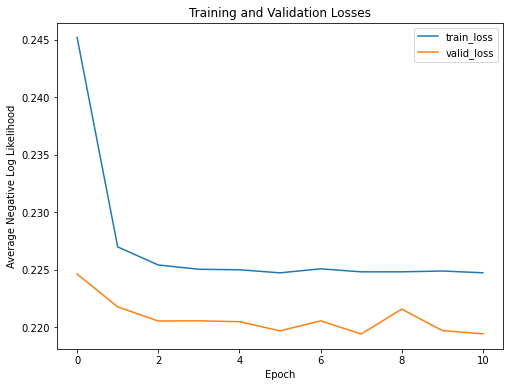

0.5805785123966942


In [ ]:
plot_loss(history)
print(test_simple(model, test_loader)[1])

We achieve best performance of ~59% with the basic network

# Deep Score Prediction Network

The first network we try uses games from 2012-2020 PPG and PAPG over the last 10.

In [ ]:
def test(model, test_loader, Print=False):
  y_pred_list = []
  with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())

  y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
  return y_pred_list

def test_net_spreads(network, columns, betting, games, n):
  with torch.no_grad():
    model.eval()

    join = pd.merge(games, betting, left_on=['GAME_ID'], right_on=['game_id'])

    X = join[columns]
    Y = join[['PTS_home', 'PTS_away', 'spread2', 'total1']]

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X = np.array(X)
    Y = np.array(Y)
    Y = Y.astype(float)

    X = torch.from_numpy(X).float()

    correct_o_u = 0.
    correct_spread = 0.
    total = 0
    for x, y in zip(X, Y):
        x = x.to(device)
        y_test_pred = model(x).cpu().tolist()

        # spread is true if home team beats the spread
        test_spread = (y_test_pred[0] - y_test_pred[1] + y[2]) > 0
        # o_u is true if the over hits
        test_o_u = y_test_pred[0] + y_test_pred[1] - y[3] > 0
        # spread is true if home team beats the spread
        spread = (y[0] - y[1] + y[2]) > 0
        # o_u is true if the over hits
        o_u = y[0] + y[1] - y[3] > 0

        correct_o_u += test_o_u == o_u
        correct_spread += test_spread == spread
        total += 1

    return {'o/u': correct_o_u / total * 100, 'spread': correct_spread / total * 100}

In [ ]:
pts_data = data.loc[data['SEASON'].isin(range(2012, 2021))]
X = pts_data[['PTS_homeL10', 'PTS_against_homeL10', 'PTS_awayL10', 'PTS_against_awayL10']]
Y = pts_data[['PTS_home', 'PTS_away']]

# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size=0.1, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 25

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
# define model
# plan to input each teams PPG for the season, PPG last 10 game, PAPG for the season, PAPG last 10 games
class ScoresModelDeep(nn.Module):
    def __init__(self, nin, nout):
        super(ScoresModelDeep, self).__init__()
        
        self.lin1 = nn.Linear(nin, 8)
        self.lin2 = nn.Linear(8, 16)
        self.lin3 = nn.Linear(16, 12)
        self.lin4 = nn.Linear(12, 6)
        self.out = nn.Linear(6, nout)
        
        self.dropout = nn.Dropout(0)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.relu(self.lin2(x))
        x = self.dropout(x)
        x = self.relu(self.lin3(x))
        x = self.dropout(x)
        x = self.relu(self.lin4(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [ ]:
lr = .00005
nin = len(X.columns)
nout = len(Y.columns)

model = ScoresModelDeep(nin, nout)
epochs = 150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model, history = train(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    val_loader, 
    n_epochs=epochs)

cuda:0


ScoresModelDeep(
  (lin1): Linear(in_features=4, out_features=8, bias=True)
  (lin2): Linear(in_features=8, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=12, bias=True)
  (lin4): Linear(in_features=12, out_features=6, bias=True)
  (out): Linear(in_features=6, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 11227.4923 	Validation Loss: 11098.0956

Epoch: 1 	Training Loss: 11220.0077 	Validation Loss: 11089.2636

Epoch: 2 	Training Loss: 11207.5151 	Validation Loss: 11072.7644

Epoch: 3 	Training Loss: 11184.8825 	Validation Loss: 11042.7526

Epoch: 4 	Training Loss: 11143.5778 	Validation Loss: 10988.3370

Epoch: 5 	Training Loss: 11070.5369 	Validation Loss: 10894.6360

Epoch: 6 	Training Loss: 10949.5257 	Validation Loss: 10744.6688

Epoch: 7 	Training Loss: 10762.9036 	Validation Loss: 10520.6249

Epoch: 8 	Training Loss: 10493.3211 	Validation Loss: 10205.8021

Epoch: 9 	Training Loss: 10124.3542 	Validation Loss: 9784.8282

Epoch: 10 	Training Loss: 9643.1194 	Validation Loss: 9247.7519

Epoch: 11 	Training Loss: 9041.6787 	Validation Loss: 8589.6217

Epoch: 12 	Training Loss: 8318.3635 	Validation Loss: 7809.4809

Epoch: 13 	Training Loss: 7473.8171 	Validation Loss: 6919.3819

Epoch: 14 	Training Loss: 6534.0816 	Validation

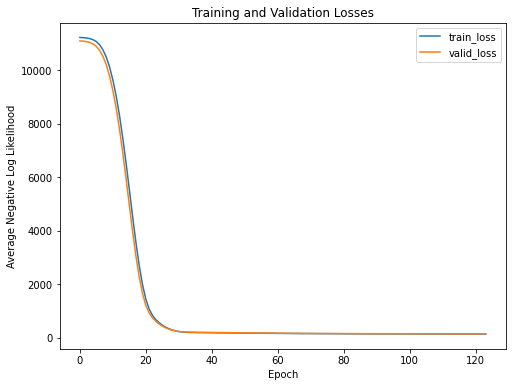

In [ ]:
plot_loss(history)

In [ ]:
y_pred = test(model, test_loader)
# for i in range(len(y_pred)):
#   print((y_pred[i], y_test[i]))
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 136.2347269606737
R^2 : 0.16291042735246175


In [ ]:
columns = X.columns
print(test_net_spreads(model, columns, betting, games, 1))

{'o/u': 49.7089481521592, 'spread': 50.38581291457967}


We achieve MSE of 134.15 and R^2 of 0.1758 with the above network. Now we incorporate team wins over the last 10 as well and see if the model is more predictive. It predicts the over/under 49.7089% of the time and the spread 50.3858. 

In [ ]:
pts_data = data.loc[data['SEASON'].isin(range(2012, 2020))]
X = pts_data[['PTS_homeL10', 'PTS_against_homeL10', 'TEAM_WINS_homeL10', 'PTS_awayL10', 'PTS_against_awayL10', 'TEAM_WINS_awayL10']]
Y = pts_data[['PTS_home', 'PTS_away']]

# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size=0.2, random_state=68)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

In [ ]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 10

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
lr = .001 / (2 ** 3)
nin = len(X.columns)
nout = len(Y.columns)

model = ScoresModelDeep(nin, nout)
epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model, history = train(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    val_loader,
    10,
    n_epochs=epochs)

cuda:0


ScoresModelDeep(
  (lin1): Linear(in_features=6, out_features=8, bias=True)
  (lin2): Linear(in_features=8, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=12, bias=True)
  (lin4): Linear(in_features=12, out_features=6, bias=True)
  (out): Linear(in_features=6, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
  (relu): ReLU()
)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 11244.9370 	Validation Loss: 11200.2904

Epoch: 1 	Training Loss: 10789.5608 	Validation Loss: 9835.6242

Epoch: 2 	Training Loss: 7101.8151 	Validation Loss: 3725.6233

Epoch: 3 	Training Loss: 1523.2446 	Validation Loss: 534.7177

Epoch: 4 	Training Loss: 375.0415 	Validation Loss: 267.7247

Epoch: 5 	Training Loss: 236.1983 	Validation Loss: 211.3087

Epoch: 6 	Training Loss: 210.1415 	Validation Loss: 202.8883

Epoch: 7 	Training Loss: 204.4224 	Validation Loss: 200.1016

Epoch: 8 	Training Loss: 200.0865 	Validation Loss: 194.0327

Epoch: 9 	Training Loss: 195.3553 	Validation Loss: 190.3640

Epoch: 10 	Training Loss: 190.4989 	Validation Loss: 185.0675

Epoch: 11 	Training Loss: 185.8356 	Validation Loss: 181.3046

Epoch: 12 	Training Loss: 180.9806 	Validation Loss: 177.7555

Epoch: 13 	Training Loss: 176.6467 	Validation Loss: 172.9172

Epoch: 14 	Training Loss: 172.6542 	Validation Loss: 169.1102

Epoch: 15 	Training L

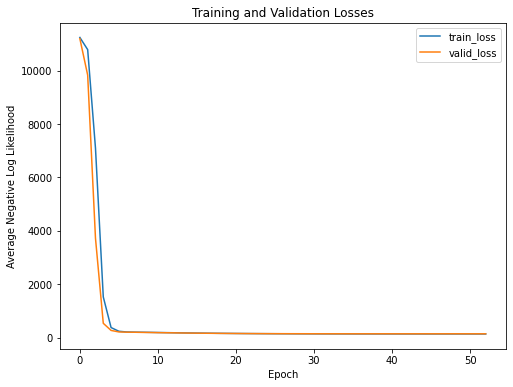

Mean Squared Error : 144.53066848681812
R^2 : 0.1544234785078818


In [ ]:
plot_loss(history)

y_pred = test(model, test_loader)
# for i in range(len(y_pred)):
#   print((y_pred[i], y_test[i]))
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

In [ ]:
columns = X.columns
print(test_net_spreads(model, columns, betting, games, 1))

{'o/u': 49.18099363747123, 'spread': 50.39935020982808}


# Deeper Networks

In [ ]:
# define model
class ScoresModelV2(nn.Module):
    def __init__(self, nin, nout, dropout, middleLayer = False):
        super(ScoresModelV2, self).__init__()
        
        self.lin1 = nn.Linear(nin, 8)
        self.lin2 = nn.Linear(8, 16)
        self.lin3 = nn.Linear(16, 24)
        if middleLayer:
          self.lin4 = nn.Linear(24, 24)
        self.lin5 = nn.Linear(24, 12)
        self.lin6 = nn.Linear(12, 6)
        self.out = nn.Linear(6, nout)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.middleLayer = middleLayer

    def forward(self, x):
        x = self.relu(self.lin1(x))
        x = self.relu(self.lin2(x))
        x = self.dropout(x)
        x = self.relu(self.lin3(x))
        x = self.dropout(x)
        if self.middleLayer:
          x = self.relu(self.lin4(x))
          x = self.dropout(x)
        x = self.relu(self.lin5(x))
        x = self.dropout(x)
        x = self.relu(self.lin6(x))
        x = self.out(x)
        return x

In [ ]:
pts_data = data.loc[data['SEASON'].isin(range(2012, 2020))]
pts_data['TOTAL_POINTS'] = pts_data['PTS_home'] + pts_data['PTS_away']

X = pts_data[['PTS_homeL10', 'PTS_against_homeL10', 'TEAM_WINS_homeL10', 'PTS_awayL10', 'PTS_against_awayL10', 'TEAM_WINS_awayL10']]
# X = pts_data[['PTS_homeL10', 'PTS_against_homeL10', 'PTS_awayL10', 'PTS_against_awayL10']]
Y = pts_data[['PTS_home', 'PTS_away']]

# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size=0.2, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 25

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
lr = .0001
nin = len(X.columns)
nout = len(Y.columns)

model = ScoresModelV2(nin, nout, .3, False)
epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model, history = train(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    val_loader, 
    10,
    n_epochs=epochs)

cuda:0


ScoresModelV2(
  (lin1): Linear(in_features=6, out_features=8, bias=True)
  (lin2): Linear(in_features=8, out_features=16, bias=True)
  (lin3): Linear(in_features=16, out_features=24, bias=True)
  (lin5): Linear(in_features=24, out_features=12, bias=True)
  (lin6): Linear(in_features=12, out_features=6, bias=True)
  (out): Linear(in_features=6, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 11231.3314 	Validation Loss: 11311.2323

Epoch: 1 	Training Loss: 11208.5577 	Validation Loss: 11272.5869

Epoch: 2 	Training Loss: 11009.9809 	Validation Loss: 10673.4327

Epoch: 3 	Training Loss: 9060.0612 	Validation Loss: 6543.1583

Epoch: 4 	Training Loss: 3613.9699 	Validation Loss: 1017.9432

Epoch: 5 	Training Loss: 1554.1846 	Validation Loss: 501.9562

Epoch: 6 	Training Loss: 1404.8056 	Validation Loss: 397.2246

Epoch: 7 	Training Loss: 1380.2858 	Validation Loss: 381.7530

Epoch: 8 	Training Loss: 1329.2793 	Validation Loss: 393.0861

Epoch: 9 	Training Loss: 1345.0994 	Validation Loss: 374.4917

Epoch: 10 	Training Loss: 1319.7472 	Validation Loss: 354.6952

Epoch: 11 	Training Loss: 1304.0679 	Validation Loss: 333.5713

Epoch: 12 	Training Loss: 1300.1491 	Validation Loss: 336.3726

Epoch: 13 	Training Loss: 1240.3472 	Validation Loss: 348.1765

Epoch: 14 	Training Loss: 1208.3394 	Validation Loss: 339.0975

Epoch

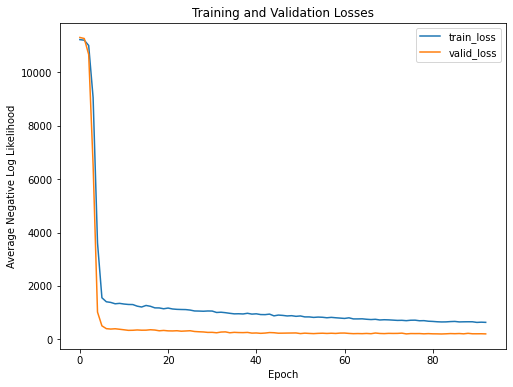

Mean Squared Error : 168.44806527626355
R^2 : -0.05377303004066758


In [ ]:
plot_loss(history)

y_pred = test(model, test_loader)
# for i in range(len(y_pred)):
#   print((y_pred[i], y_test[i]))
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

In [ ]:
columns = X.columns
print(test_net_spreads(model, columns, betting, games, 1))

{'o/u': 50.994991200758086, 'spread': 50.291051847840805}


The deeper network appears to work worse on our data inputs than the simpler network. Now we try with larger input set over last ten games. 

In [ ]:
pts_data = data.loc[data['SEASON'].isin(range(2016, 2021))]
columns = []
for i in pts_data:
  if 'L10' in i and not 'against' in i:
    columns.append(i)
X = pts_data[columns]
Y = pts_data[['PTS_home', 'PTS_away']]#pts_data[['HOME_TEAM_WINS']]
print((len(columns), columns))

# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size=0.2, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 40

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

(14, ['PTS_homeL10', 'FG_PCT_homeL10', 'FT_PCT_homeL10', 'FG3_PCT_homeL10', 'AST_homeL10', 'REB_homeL10', 'TEAM_WINS_homeL10', 'PTS_awayL10', 'FG_PCT_awayL10', 'FT_PCT_awayL10', 'FG3_PCT_awayL10', 'AST_awayL10', 'REB_awayL10', 'TEAM_WINS_awayL10'])


In [ ]:
# define model
# plan to input each teams PPG for the season, PPG last 10 game, PAPG for the season, PAPG last 10 games
class ScoresModelV3(nn.Module):
    def __init__(self, nin, nout, dropout):
        super(ScoresModelV3, self).__init__()
        
        self.lin1 = nn.Linear(nin, 48)
        self.lin2 = nn.Linear(48, 96)
        self.lin3 = nn.Linear(96, 48)
        self.lin4 = nn.Linear(48, 24)
        self.lin5 = nn.Linear(24, 8)
        self.out = nn.Linear(8, nout)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.relu(self.lin2(x))
        x = self.dropout(x)
        x = self.relu(self.lin3(x))
        x = self.dropout(x)
        x = self.relu(self.lin4(x))
        x = self.dropout(x)
        x = self.relu(self.lin5(x))
        x = self.dropout(x)
        x = self.out(x)
        return x

In [ ]:
lr = .001 / 2 ** 1
nin = len(X.columns)
nout = len(Y.columns)

model = ScoresModelV3(nin, nout, 0)
epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model, history = train(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    val_loader, 
    10,
    n_epochs=epochs)

cuda:0


ScoresModelV3(
  (lin1): Linear(in_features=14, out_features=48, bias=True)
  (lin2): Linear(in_features=48, out_features=96, bias=True)
  (lin3): Linear(in_features=96, out_features=48, bias=True)
  (lin4): Linear(in_features=48, out_features=24, bias=True)
  (lin5): Linear(in_features=24, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0, inplace=False)
)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 11871.7266 	Validation Loss: 11761.9141

Epoch: 1 	Training Loss: 10909.5552 	Validation Loss: 7567.8634

Epoch: 2 	Training Loss: 1960.4507 	Validation Loss: 269.2673

Epoch: 3 	Training Loss: 272.0545 	Validation Loss: 246.8064

Epoch: 4 	Training Loss: 264.5884 	Validation Loss: 243.3010

Epoch: 5 	Training Loss: 260.7284 	Validation Loss: 239.1562

Epoch: 6 	Training Loss: 256.4605 	Validation Loss: 235.1834

Epoch: 7 	Training Loss: 252.0508 	Validation Loss: 232.3721

Epoch: 8 	Training Loss: 247.0384 	Validation Loss: 226.2536

Epoch: 9 	Training Loss: 241.3301 	Validation Loss: 221.7306

Epoch: 10 	Training Loss: 236.2649 	Validation Loss: 217.8092

Epoch: 11 	Training Loss: 231.3753 	Validation Loss: 214.6273

Epoch: 12 	Training Loss: 226.0924 	Validation Loss: 208.2320

Epoch: 13 	Training Loss: 220.5447 	Validation Loss: 203.5484

Epoch: 14 	Training Loss: 215.2315 	Validation Loss: 199.7603

Epoch: 15 	Training Los

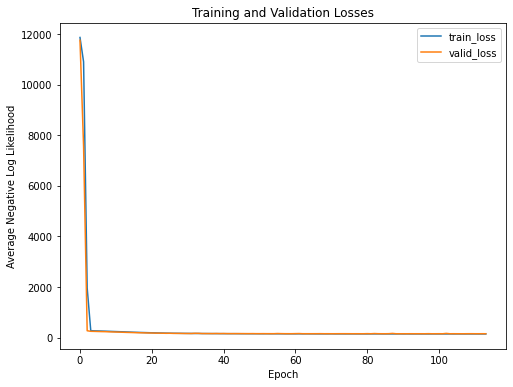

([102.80130767822266, 100.46253967285156], array([111., 120.]))
([113.97669219970703, 111.3792495727539], array([121., 111.]))
([111.40335083007812, 108.865478515625], array([117., 104.]))
([109.31849670410156, 106.82887268066406], array([112., 127.]))
([109.19841766357422, 106.71157836914062], array([ 79., 109.]))
([101.55472564697266, 99.24480438232422], array([103.,  89.]))
([107.09207916259766, 104.65399169921875], array([118., 109.]))
([110.62157440185547, 108.10179138183594], array([114.,  98.]))
([111.7173843383789, 109.1722412109375], array([123., 112.]))
([114.9141845703125, 112.2950439453125], array([135., 133.]))
Mean Squared Error : 136.95111190818568
R^2 : 0.10767465432954093


In [ ]:
plot_loss(history)
y_pred = test(model, test_loader)
# for i in range(10):
#   print((y_pred[i], y_test[i]))
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

In [ ]:
columns = X.columns

print(test_net_spreads(model, columns, betting, games, 10))

{'o/u': 49.7089481521592, 'spread': 50.38581291457967}


Now with all features

In [ ]:
pts_data = games.loc[games['SEASON'].isin(range(2010, 2020))]
Y = pts_data[['PTS_home', 'PTS_away']]
for i in pts_data:
  if not ('AVG' in i or 'L10' in i):
    pts_data = pts_data.drop([i], 1)
X = pts_data
#pts_data[['HOME_TEAM_WINS']]

# Train - Test
X_trainval, X_test, y_trainval, y_test = train_test_split(X, Y, test_size=0.2, random_state=69)
# Split train into train-val
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, random_state=21)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

In [ ]:
print(X.shape)

(8240, 52)


In [ ]:
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

batch_size = 25

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

In [ ]:
# define model
# plan to input each teams PPG for the season, PPG last 10 game, PAPG for the season, PAPG last 10 games
class ScoresModelV3(nn.Module):
    def __init__(self, nin, nout):
        super(ScoresModelV3, self).__init__()
        
        self.lin1 = nn.Linear(nin, 100)
        self.lin2 = nn.Linear(100, 75)
        self.lin3 = nn.Linear(75, 52)
        self.lin4 = nn.Linear(52, 16)
        self.lin5 = nn.Linear(16, 4)
        self.out = nn.Linear(4, nout)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(.5)

    def forward(self, x):
        x = self.relu(self.lin1(x))
        x = self.dropout(x)
        x = self.relu(self.lin2(x))
        x = self.dropout(x)
        x = self.relu(self.lin3(x))
        x = self.dropout(x)
        x = self.relu(self.lin4(x))
        x = self.dropout(x)
        x = self.relu(self.lin5(x))
        x = self.out(x)
        return x

In [ ]:
lr = .001
nin = len(X.columns)
nout = len(Y.columns)

model = ScoresModelV3(nin, nout)
epochs = 150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model, history = train(
    model, 
    criterion, 
    optimizer, 
    train_loader, 
    val_loader, 
    n_epochs=epochs)

cuda:0


ScoresModelV3(
  (lin1): Linear(in_features=52, out_features=100, bias=True)
  (lin2): Linear(in_features=100, out_features=75, bias=True)
  (lin3): Linear(in_features=75, out_features=52, bias=True)
  (lin4): Linear(in_features=52, out_features=16, bias=True)
  (lin5): Linear(in_features=16, out_features=4, bias=True)
  (out): Linear(in_features=4, out_features=2, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 3105.3920 	Validation Loss: 573.0261

Epoch: 1 	Training Loss: 1381.8805 	Validation Loss: 753.7540

Epoch: 2 	Training Loss: 1228.8467 	Validation Loss: 1348.4237

Epoch: 3 	Training Loss: 1132.4418 	Validation Loss: 1757.8172

Epoch: 4 	Training Loss: 1102.8595 	Validation Loss: 1668.3127

Epoch: 5 	Training Loss: 1010.3030 	Validation Loss: 1598.4186

Epoch: 6 	Training Loss: 1002.7076 	Validation Loss: 1973.8024

Epoch: 7 	Training Loss: 1000.5432 	Validation Loss: 2300.0458

Epoch: 8 	Training Loss: 931.8177 	Validation Loss: 1746.9245

Epoch: 9 	Training Loss: 925.7066 	Validation Loss: 1854.4044

Epoch: 10 	Training Loss: 901.8805 	Validation Loss: 1596.6259

Epoch: 11 	Training Loss: 833.7618 	Validation Loss: 1596.3336

Epoch: 12 	Training Loss: 801.3479 	Validation Loss: 1764.9359

Epoch: 13 	Training Loss: 753.6256 	Validation Loss: 1639.0279

Epoch: 14 	Training Loss: 732.4100 	Validation Loss: 1184.7133

Epoch: 15 

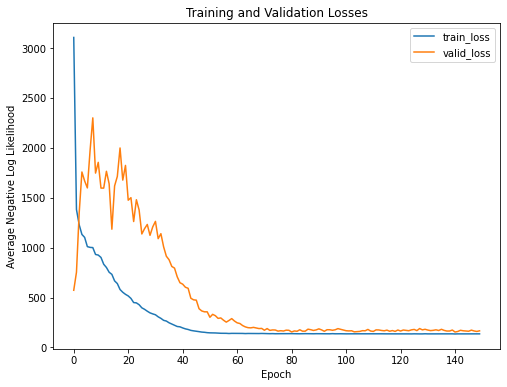

In [ ]:
plot_loss(history)

In [ ]:
y_pred = test(model, test_loader)
# for i in range(len(y_pred)):
#   print((y_pred[i], y_test[i]))
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 173.60527168555674
R^2 : -0.01638117801554939
